#Assignment 1 - Machine Learning

Author: Clara Gauer

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import warnings
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
#Import the CSV file
!wget -cq https://www.dropbox.com/s/n0t1fi534rhycoc/electrical_grid_train.csv

In [ ]:
#Check the location of the file
!ls -la

total 1700
drwxr-xr-x 1 root root    4096 Apr 10 18:22 .
drwxr-xr-x 1 root root    4096 Apr 10 14:14 ..
drwxr-xr-x 4 root root    4096 Apr  8 13:26 .config
-rw-r--r-- 1 root root  428879 Apr 10 14:16 electrical_grid_test.csv
-rw-r--r-- 1 root root 1286444 Apr 10 14:16 electrical_grid_train.csv
drwxr-xr-x 1 root root    4096 Apr  8 13:27 sample_data
-rw-r--r-- 1 root root     733 Apr 10 18:22 xgb_model.pkl


In [ ]:
# Reading the datasets
train_data = pd.read_csv('electrical_grid_train.csv')

In [ ]:
# Since stability is catgecorical data, which only has the values "stable" and "unstable", perform One Hot Encoding in order to retrieve numerical values
train_data.replace({'unstable':0, 'stable':1}, inplace=True)

In [ ]:
# Tuple containing the number of rows and number of columns
train_data.shape

(7500, 13)

In [ ]:
# Check for null values in the data set
train_data.isnull().sum()

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stabf    0
dtype: int64

Here, we can observe that there are no null values. This implies we are not required to handle missing values extra. Otherwise, if missing values are present, it could lead to a bias in the dataset since data of certain features are not present. If the dataset is not complete, it would be required to drop the column.

In [ ]:
# Provides information about storage, data type, amount of entries
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    7500 non-null   float64
 1   tau2    7500 non-null   float64
 2   tau3    7500 non-null   float64
 3   tau4    7500 non-null   float64
 4   p1      7500 non-null   float64
 5   p2      7500 non-null   float64
 6   p3      7500 non-null   float64
 7   p4      7500 non-null   float64
 8   g1      7500 non-null   float64
 9   g2      7500 non-null   float64
 10  g3      7500 non-null   float64
 11  g4      7500 non-null   float64
 12  stabf   7500 non-null   int64  
dtypes: float64(12), int64(1)
memory usage: 761.8 KB


In [ ]:
# Show the first five data points
train_data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,5.744900,8.203603,5.744900,4.742819,4.428855,-1.206951,-1.996184,-1.225720,0.062127,0.910284,0.347608,0.203486,0
1,4.765284,7.227511,4.765284,8.589188,3.464720,-1.709124,-0.709637,-1.045959,0.790823,0.939275,0.556773,0.735869,0
2,7.603216,1.556791,5.475538,1.954418,3.196611,-1.845370,-0.501266,-0.849976,0.724277,0.849737,0.825894,0.441910,1
3,6.931945,1.706944,6.931945,6.623881,4.503907,-1.323009,-1.287506,-1.893392,0.077234,0.320062,0.332532,0.612462,1
4,1.604168,0.937741,1.604168,5.102720,5.119059,-1.886555,-1.694975,-1.537529,0.251807,0.382606,0.768862,0.063126,1


In [ ]:
# Calculates the minimum value accross all columns
train_data.min().min()

-1.999944669

In [ ]:
# Calculates the maximum value accross all columns
train_data.max().max()

9.998994574

In [ ]:
# For numerical values, .describe() will provide non-zero values, the average mean, standard deviation, quantiles and the minimum and maximum value
train_data.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,5.228858,4.520797,5.210976,5.241762,3.754731,-1.251220,-1.252692,-1.250819,0.524319,0.524514,0.526879,0.525536,0.361333
std,2.738370,2.752313,2.739522,2.730348,0.754559,0.433091,0.434412,0.434051,0.274333,0.272314,0.274261,0.275539,0.480419
min,0.501331,-0.225671,0.501331,0.500473,1.582590,-1.999891,-1.999945,-1.999926,0.050009,0.050130,0.050054,0.050028,0.000000
25%,2.866791,2.132227,2.849581,2.866707,3.222427,-1.628732,-1.629679,-1.625914,0.286928,0.291268,0.289900,0.284966,0.000000
50%,5.218495,4.505940,5.213907,5.234666,3.750117,-1.253129,-1.254323,-1.252545,0.521737,0.524857,0.527572,0.523747,0.000000
75%,7.587219,6.911618,7.579382,7.596421,4.287058,-0.874619,-0.875935,-0.874258,0.762534,0.759162,0.764014,0.766536,1.000000
max,9.998995,9.274024,9.997738,9.998912,5.864418,-0.500108,-0.500290,-0.500025,0.999937,0.999944,0.999839,0.999930,1.000000


In [ ]:
# Determine positive and negative correlations (1 being a perfect correlation, 0 no correlation, -1 a perfect negative correlation)
train_data.corr()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
tau1,1.000000,0.018327,0.897324,-0.008974,0.031162,-0.018839,-0.019588,-0.015770,0.007780,0.017797,-0.005001,0.003678,-0.241021
tau2,0.018327,1.000000,0.021616,-0.005647,-0.004316,0.010340,0.008914,-0.011734,-0.007413,0.017506,0.028040,-0.005822,-0.246724
tau3,0.897324,0.021616,1.000000,-0.013984,0.026722,-0.023971,-0.006389,-0.016142,0.001329,0.008139,-0.009687,0.006779,-0.206812
tau4,-0.008974,-0.005647,-0.013984,1.000000,-0.009866,0.011039,0.016204,-0.010080,-0.013931,0.011775,0.005236,-0.003716,-0.236687
p1,0.031162,-0.004316,0.026722,-0.009866,1.000000,-0.573440,-0.584818,-0.580935,-0.005019,0.026612,0.001476,-0.017816,-0.018572
p2,-0.018839,0.010340,-0.023971,0.011039,-0.573440,1.000000,0.002514,-0.003430,0.021536,-0.026247,0.000339,0.018890,-0.008119
p3,-0.019588,0.008914,-0.006389,0.016204,-0.584818,0.002514,1.000000,0.013315,0.000929,-0.012074,-0.002953,-0.006246,0.002483
p4,-0.015770,-0.011734,-0.016142,-0.010080,-0.580935,-0.003430,0.013315,1.000000,-0.013694,-0.007990,0.000052,0.018373,0.037901
g1,0.007780,-0.007413,0.001329,-0.013931,-0.005019,0.021536,0.000929,-0.013694,1.000000,0.005393,-0.009658,0.007221,-0.197329
g2,0.017797,0.017506,0.008139,0.011775,0.026612,-0.026247,-0.012074,-0.007990,0.005393,1.000000,-0.022642,-0.020621,-0.216758


<Axes: >

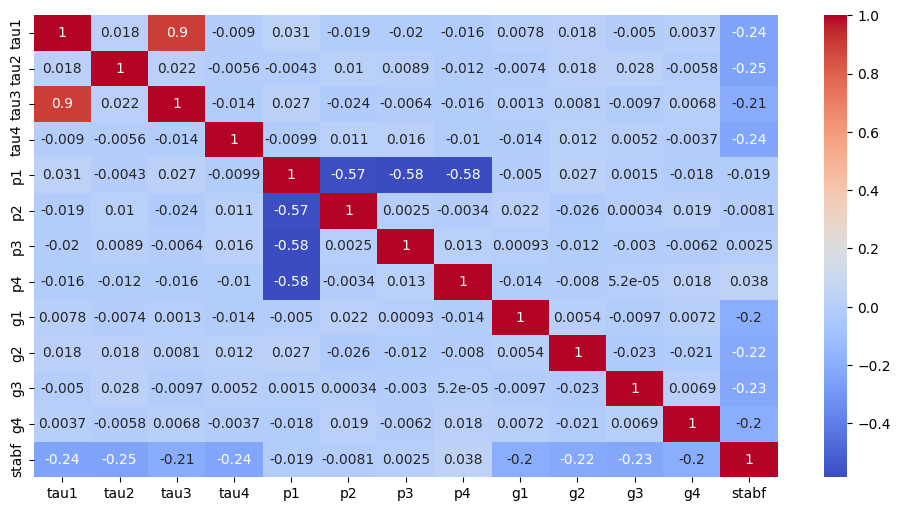

In [ ]:
# Create a heatmap in order to visualize the correlation matrix of the train_data DataFrame
plt.figure(figsize=(12, 6))
sns.heatmap(train_data.corr(), cmap='coolwarm', annot=True)

There is a strong collinearity between feature p1 and p2, p3, p4 and a very strong collinearity between feature tau1 and tau3.

Since a heatmap displays correlation coefficients, we aim for a value of 0 or close to 0. If some values are not close to 0, they are said to be dependent, while independence is required in order to provide unique information to the analysis. Furthermore, dependency can lead to multicollinearity, which means that the effect of a sole variable can not be seperated from the other variable. Thus, dependent variables will have redundant informations about the target variable.

"tau1" has a very strong correlation of 0.9 between tau1 and tau3. Furthermore, there is a strong negative correlation of -0.58 between (p1, p3) & (p1, p4) and a strong negative correlation of -0.57 between (p1, p2).
Thus, it makes sense to drop "p1" and "tau1".

In [ ]:
# Delete feature with strong collinearity
train_data = train_data.drop(['p1', 'tau1'], axis=1)

In [ ]:
# Determine positive and negative correlations (1 being a perfect correlation, 0 no correlation, -1 a perfect negative correlation)
train_data.corr()

,tau2,tau3,tau4,p2,p3,p4,g1,g2,g3,g4,stabf
tau2,1.000000,0.021616,-0.005647,0.010340,0.008914,-0.011734,-0.007413,0.017506,0.028040,-0.005822,-0.246724
tau3,0.021616,1.000000,-0.013984,-0.023971,-0.006389,-0.016142,0.001329,0.008139,-0.009687,0.006779,-0.206812
tau4,-0.005647,-0.013984,1.000000,0.011039,0.016204,-0.010080,-0.013931,0.011775,0.005236,-0.003716,-0.236687
p2,0.010340,-0.023971,0.011039,1.000000,0.002514,-0.003430,0.021536,-0.026247,0.000339,0.018890,-0.008119
p3,0.008914,-0.006389,0.016204,0.002514,1.000000,0.013315,0.000929,-0.012074,-0.002953,-0.006246,0.002483
p4,-0.011734,-0.016142,-0.010080,-0.003430,0.013315,1.000000,-0.013694,-0.007990,0.000052,0.018373,0.037901
g1,-0.007413,0.001329,-0.013931,0.021536,0.000929,-0.013694,1.000000,0.005393,-0.009658,0.007221,-0.197329
g2,0.017506,0.008139,0.011775,-0.026247,-0.012074,-0.007990,0.005393,1.000000,-0.022642,-0.020621,-0.216758
g3,0.028040,-0.009687,0.005236,0.000339,-0.002953,0.000052,-0.009658,-0.022642,1.000000,0.006945,-0.231643
g4,-0.005822,0.006779,-0.003716,0.018890,-0.006246,0.018373,0.007221,-0.020621,0.006945,1.000000,-0.198284


<Axes: >

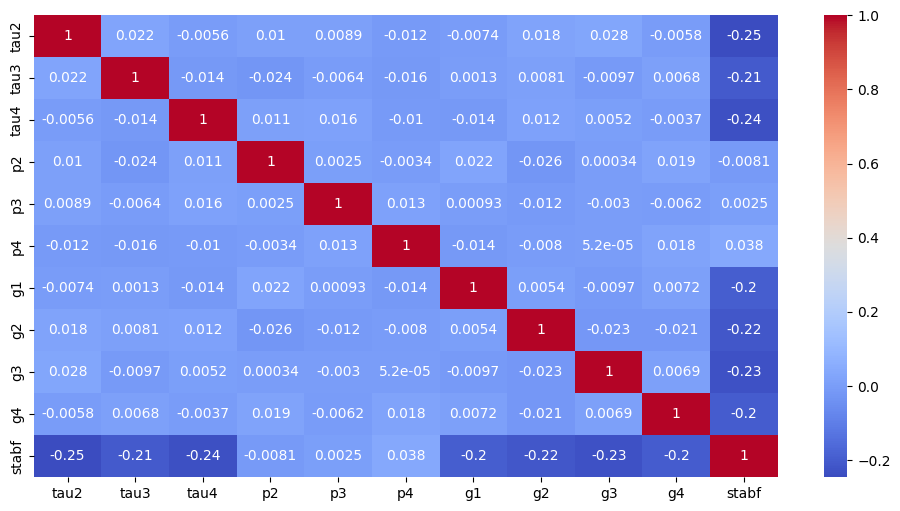

In [ ]:
# Create a heatmap in order to visualize the correlation matrix of the train_data DataFrame
plt.figure(figsize=(12, 6))
sns.heatmap(train_data.corr(), cmap='coolwarm', annot=True)

Variables with a strong correlation have been deleted. After deletion, only a few values are left with a weak negative correlation, which we must not consider. As a consequence, most present variables can be considered independent from each other.
The values the furthest away from 0 are features correlating with stabf, which is being deleted in the next step since it is the value we want to predict.

# Model and Hyperparameter


In [ ]:
# Seperate the features (X) from the target variable (y) in the DataFrame
X = train_data.drop('stabf', axis=1)
y = train_data.stabf

# 1. Naive Bayes classifier

The Naive Bayes classifier is a simple yet powerful probabilistic algorithm used for classification tasks. Despite its simplicity and the "naive" assumption of independent features, Naive Bayes often performs remarkably well, especially with large datasets and when the independence assumption holds reasonably well.

In [ ]:
# Importing necessary libraries
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.naive_bayes import GaussianNB

In [ ]:
# Defining the parameter grid for Gaussian Naive Bayes
params_gnb = {
    'var_smoothing': [1e-7, 1e-6, 1e-5],  # Variance smoothing parameter
}

# Instantiating Gaussian Naive Bayes
gnb = GaussianNB()

# Instantiating GridSearchCV
model_grid = GridSearchCV(gnb, param_grid = params_gnb, cv=5, verbose=2, n_jobs=-1)

# Fitting GridSearchCV to find the best hyperparameters
model_grid.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-07, 1e-06, 1e-05]}, verbose=2)

In [ ]:
# Accessing the best hyperparameters found by the GridSearchCV for Naive Bayes
model_grid.best_params_

{'var_smoothing': 1e-07}

In [ ]:
# Model configuration that yielded the highest performance based on the evaluation metric & cross-validation
model_grid.best_estimator_

GaussianNB(var_smoothing=1e-07)

In [ ]:
#  Mean cross-validated score of the best model configuration
model_grid.best_score_

0.8025333333333332

In [ ]:
# Predicting the target variable using the trained model on the entire training set
y_pred = model_grid.predict(X)

# Print prediction results
print('Prediction with whole training set')
print(f'Accuracy is {accuracy_score(y, y_pred)}')
print(f'F1 score is {f1_score(y, y_pred)}')
print(f'Recall is {recall_score(y, y_pred)}')
print(f'Precision is {precision_score(y, y_pred)}')

Prediction with whole training set
Accuracy is 0.8036
F1 score is 0.6931889189752135
Recall is 0.6140221402214022
Precision is 0.795791487326638


# 2. Random Forest

Random Forest is a versatile learning algorithm used for classification tasks. It operates by constructing many decision trees during training and it outputs the mode of the classes of the individual trees.
The benefits of Random Forest are robustness to noisy data, ability to manage high-dimensional fesature spaces and resistance to overfitting.

In [ ]:
# Defining the parameter grid for Random Forest
params_rf = {
    'criterion' : ['gini', 'entropy'], # Criteria for information gain calculation
    'max_depth': [6, 7, 8], # Maximum depth of each tree in the forest
    'n_estimators': [50, 100], # Number of trees in the forest
    'max_features': ['sqrt', 0.5], # Number of features to consider when looking for the best split
    'random_state': [2] # Random state for reproducibility
}

# Instantiate RandomForestClassifier
rf = RandomForestClassifier(oob_score=True)

# Instantiate GridSearchCV with reduced parameter grid
model_grid = GridSearchCV(rf, param_grid = params_rf, cv=5, verbose=2, n_jobs=-1)

# Fit GridSearchCV
model_grid.fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(oob_score=True), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [6, 7, 8], 'max_features': ['sqrt', 0.5],
                         'n_estimators': [50, 100], 'random_state': [2]},
             verbose=2)

The grid search is using 5-fold cross-validation during the evaluation of each hyperparameter combinatino. Thus, the data is divided into 5 equal-sized folds, and the model is trained and evaluated 5 times.

---

There are 24 candidates which means that 24 different combinations of hyperparameters are being evaluated.

---

In total, there are 120 fits (training and evaluation cycles) that will be performed during the grid search process. Since there are 24 candidate combinations and each combination is evaluated using 5-fold cross-validation, the total number is 24*5 = 120

In [ ]:
# Accessing the best hyperparameters found by the GridSearchCV for Random Forest
model_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 0.5,
 'n_estimators': 100,
 'random_state': 2}

The **criterion** used for splitting nodes is entropy.

---

The **maximum depth** of the decision tree is 8, meaning a decision tree cannot surpass , limiting the possibility of overfitting and reducing complexity of the model.  

---

A **max_features** of 0.5 means that at each split, the algorithm will randomly select half the features to consider when looking for the best split.

---

**n_estimators** of 100 show that 100 trees yield the best performance in the random forest

---

A **random_state** of 2 sets the random seed for reproducibility. It ensures that results are consistent across different runs of the algorithm.



In [ ]:
# Model configuration that yielded the highest performance based on the evaluation metric & cross-validation
model_grid.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=8, max_features=0.5,
                       oob_score=True, random_state=2)

In [ ]:
# Mean cross-validated score of the best model configuration
model_grid.best_score_

0.8494666666666667

In [ ]:
# Counts the normalized value counts of unique values in the target variable
y.value_counts(normalize=True)

stabf
0    0.638667
1    0.361333
Name: proportion, dtype: float64

Analysis:

---

Class 0 (unstable): Proportion = 0.638667 (approximately 63.87%)
Class 1 (stable): Proportion = 0.361333 (approximately 36.13 %)



---
Class 0 constitutes approximately 63.87% of the dataset, while Class 1 constitutes approximately 36.13%. This means that the dataset is imbalanced.




In [ ]:
# Predicting the target varibale using the trained model on the entire training set
y_pred = model_grid.predict(X)

# Calculating and printing accuracy, F1 score, recall and precision
print('Prediction with whole training set (much more optimistic)')
print(f'Accuracy is {accuracy_score(y, y_pred)}')
print(f'F1 score is {f1_score(y, y_pred)}')
print(f'Recall is {recall_score(y, y_pred)}')
print(f'Precision is {precision_score(y, y_pred)}')

Prediction with whole training set (much more optimistic)
Accuracy is 0.9101333333333333
F1 score is 0.8647672552166935
Recall is 0.7952029520295203
Precision is 0.9476693051890941


# 3. XGBoost

XGBoost belongs to the family of gradient boosting algorithms, which sequentially train weak learners (typically decision trees) to correct the errors made by the previous models. It extends traditional gradient boosting by incorporating regularization techniques to control overfitting.  

In [ ]:
# Define the parameters grid for XGBoost
params_xgb = {
    'n_estimators': [500], # Fixed number of estimators
    'colsample_bytree': [0.7, 0.8], # Fraction of features to consider when building each tree
    'max_depth': [3, 4], # Maximum depth of a tree
    'reg_alpha': [1.7, 1.8], # L1 regularization term on weights
    'reg_lambda': [2.3, 2.4], # L2 regularization term on weights
    'subsample': [0.7, 0.8], # Fraction of samples to fit each tree
    'random_state': [2] # Seed for random number generator
}

# Instantiate XGBoost classifier
xgb = XGBClassifier()

# Instantiate GridSearchCV with XGBoost classifier and parameter grid
model_grid_xgb = GridSearchCV(xgb, param_grid = params_xgb, cv=5, verbose=2, n_jobs=-1)

# Fit GridSearchCV to find the best hyperparameters
model_grid_xgb.fit(X, y)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8], 'max_depth': [3, 4],
                         'n_estimators': [500], 'random_state': [2],
                         'reg_alpha': [1.7, 1.8], 'reg_lambda': [2.3, 2.4],
                         'subsample': [0.7, 0.8]},
             verbose=2)

In [ ]:
# Accessing the best hyperparameters found by the GridSearchCV for XGBoost
model_grid_xgb.best_params_

{'colsample_bytree': 0.8,
 'max_depth': 3,
 'n_estimators': 500,
 'random_state': 2,
 'reg_alpha': 1.8,
 'reg_lambda': 2.3,
 'subsample': 0.8}

In [ ]:
# Model configuration that yielded the highest performance based on the evaluation metric & cross-validation
model_grid_xgb.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=2, ...)

In [ ]:
#  Mean cross-validated score of the best model configuration
model_grid_xgb.best_score_

0.8510666666666665

In [ ]:
# Predicting the target variable using the trained model on the entire training set
y_pred = model_grid_xgb.predict(X)

# Print predicition results
print('Prediction with whole training set (much more optimistic)')
print(f'Accuracy is {accuracy_score(y, y_pred)}')
print(f'F1 score is {f1_score(y, y_pred)}')
print(f'Recall is {recall_score(y, y_pred)}')
print(f'Precision is {precision_score(y, y_pred)}')

Prediction with whole training set (much more optimistic)
Accuracy is 0.9641333333333333
F1 score is 0.9493313241665097
Recall is 0.9298892988929889
Precision is 0.9696036937283571


check if accuracy of 1 is normal

# 4. Decision Tree

A decision tree is a powerful algorithm used for classification tasks. It partitions the feature space into a tree-like structure based on the values of input features. Each internal node represents a decision based on a feature and each leaf node corresponds to a class label.

In [ ]:
# Importing necessary libraries
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Define the parameter grid for Decision Tree
params_dt = {
    'max_depth': [None, 3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Instantiate DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier()

# Instantiate GridSearchCV
model_grid = GridSearchCV(estimator=dt_classifier, param_grid=params_dt, cv=5, verbose=2, n_jobs=-1)

# Fit GridSearchCV
model_grid.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 5],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5]},
             verbose=2)

In [ ]:
#  Mean cross-validated score of the best model configuration
model_grid.best_score_

0.7772

In [ ]:
# Model configuration that yielded the highest performance based on the evaluation metric & cross-validation
model_grid.best_estimator_

DecisionTreeClassifier(max_features='log2', min_samples_leaf=2)

In [ ]:
# Accessing the best hyperparameters found by the GridSearchCV for the decision tree
model_grid.best_params_

{'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [ ]:
# Predicting the target variable using the trained model on the entire training set
y_pred = model_grid.predict(X)

# Print predicition results
print('Prediction with whole training set (much more optimistic)')
print(f'Accuracy is {accuracy_score(y, y_pred)}')
print(f'F1 score is {f1_score(y, y_pred)}')
print(f'Recall is {recall_score(y, y_pred)}')
print(f'Precision is {precision_score(y, y_pred)}')

Prediction with whole training set (much more optimistic)
Accuracy is 0.9586666666666667
F1 score is 0.9402697495183044
Recall is 0.9003690036900369
Precision is 0.9838709677419355


# 5. SVM


Support Vector Machine is a supervised learning algorithm used for classification tasks. It finds the optimal hyperplane that best separates different classes in the feature space, maximizing the margin between classes.

In [ ]:
# Importing necessary libraries
from sklearn.svm import SVC

In [ ]:
# Define the parameter grid for Support Vector Classifier (SVC)
params_svc = {
    'C': [0.1, 1, 10], # Regularization parameter
    'kernel': ['linear', 'rbf'], # Type of kernel function
    'gamma': ['scale'] # Kernel coefficient for 'rbf' kernel
}

# Instantiating Support Vector Classifier
svc = SVC()

# Instantiating Support Vector Classifier
model_grid = GridSearchCV(svc, param_grid=params_svc, cv=5, verbose=2, n_jobs=-1)

# Fitting GridSearchCV to find the best hyperparameters
model_grid.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale'],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [ ]:
# Accessing the best hyperparameters found by the GridSearchCV for the SVM
model_grid.best_params_

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
# Mean cross-validated score of the best model configuration
model_grid.best_score_

0.866

In [ ]:
# Model configuration that yielded the highest performance based on the evaluation metric & cross-validation
model_grid.best_estimator_

SVC(C=10)

In [ ]:
# Counts the normalized value counts of unique values in the target variable
y.value_counts(normalize=True)

stabf
0    0.638667
1    0.361333
Name: proportion, dtype: float64

In [ ]:
# Predicting the target variable using the trained model on the entire training set
y_pred = model_grid.predict(X)

# Print predicition results
print('Prediction with whole training set (much more optimistic)')
print(f'Accuracy is {accuracy_score(y, y_pred)}')
print(f'F1 score is {f1_score(y, y_pred)}')
print(f'Recall is {recall_score(y, y_pred)}')
print(f'Precision is {precision_score(y, y_pred)}')

Prediction with whole training set (much more optimistic)
Accuracy is 0.8733333333333333
F1 score is 0.8161764705882353
Recall is 0.7782287822878229
Precision is 0.8580146460537021


# 6. Logistic Regression

Logistic Regression is a linear model commonly used for binary classification tasks. It estimates the probability that an instance belongs to a particular class based on its features, applying a logistic function to the linear combination of input variables.

In [ ]:
# Importing necessary libraries
from sklearn.linear_model import LogisticRegression

In [ ]:
# Define the parameter grid for Logistic Regression
params_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Instantiate LogisticRegression
lr_classifier = LogisticRegression()

# Instantiate GridSearchCV
model_grid_lr = GridSearchCV(estimator=lr_classifier, param_grid=params_lr, cv=5, verbose=2, n_jobs=-1)

# Fit GridSearchCV
model_grid_lr.fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             verbose=2)

In [ ]:
# Accessing the best hyperparameters found by the GridSearchCV for the Logistic Regression
model_grid_lr.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}

In [ ]:
#  Mean cross-validated score of the best model configuration
model_grid_lr.best_score_

0.7888

In [ ]:
# Model configuration that yielded the highest performance based on the evaluation metric & cross-validation
model_grid.best_estimator_

SVC(C=10)

In [ ]:
# Predicting the target variable using the trained model on the entire training set
y_pred = model_grid.predict(X)

# Print predicition results
print('Prediction with whole training set (much more optimistic)')
print(f'Accuracy is {accuracy_score(y, y_pred)}')
print(f'F1 score is {f1_score(y, y_pred)}')
print(f'Recall is {recall_score(y, y_pred)}')
print(f'Precision is {precision_score(y, y_pred)}')

Prediction with whole training set (much more optimistic)
Accuracy is 0.8733333333333333
F1 score is 0.8161764705882353
Recall is 0.7782287822878229
Precision is 0.8580146460537021


# Final score


In [ ]:
#Import the CSV file
!wget -cq https://www.dropbox.com/s/v20v43hwmkj1bol/electrical_grid_test.csv

In [ ]:
# Show the space location
!ls -la

total 1700
drwxr-xr-x 1 root root    4096 Apr 10 18:22 .
drwxr-xr-x 1 root root    4096 Apr 10 14:14 ..
drwxr-xr-x 4 root root    4096 Apr  8 13:26 .config
-rw-r--r-- 1 root root  428879 Apr 10 14:16 electrical_grid_test.csv
-rw-r--r-- 1 root root 1286444 Apr 10 14:16 electrical_grid_train.csv
drwxr-xr-x 1 root root    4096 Apr  8 13:27 sample_data
-rw-r--r-- 1 root root     733 Apr 10 18:22 xgb_model.pkl


In [ ]:
# Read the file
test_data = pd.read_csv('electrical_grid_test.csv')

In [ ]:
# Turn 'stable' and 'unstable' into numerical data so it can be interpreted
test_data.replace({'unstable':0, 'stable':1}, inplace=True)

In [ ]:
# Show the data
test_data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,3.198395,1.998723,3.198395,6.749158,3.840354,-1.025326,-0.975754,-1.839274,0.705793,0.061484,0.655529,0.716621,0
1,7.295651,0.390647,7.295651,2.238956,2.526818,-0.850468,-1.162358,-0.513991,0.818904,0.917692,0.331460,0.161048,1
2,3.766899,5.681400,3.766899,6.464329,3.205875,-1.143055,-1.076921,-0.985898,0.721218,0.283222,0.519634,0.810315,0
3,1.412934,5.363109,1.412934,6.172790,3.388079,-0.879606,-1.127544,-1.380928,0.109811,0.633781,0.079277,0.841257,0
4,2.488778,7.751648,2.488778,5.558753,2.945201,-1.391981,-0.747310,-0.805910,0.608805,0.509664,0.622356,0.394018,0


In [ ]:
# Check if there are null values that have to be treated differently
test_data.isnull().sum()

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stabf    0
dtype: int64

In [ ]:
# Shows numerical data on each feature
test_data.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,5.313425,4.534362,5.308437,5.274702,3.735808,-1.246343,-1.241924,-1.247541,0.527042,0.526459,0.519365,0.523391,0.364000
std,2.754620,2.713567,2.738775,2.779262,0.744887,0.432931,0.428864,0.430049,0.274066,0.280048,0.274214,0.270413,0.481245
min,0.500793,-0.221684,0.500793,0.502025,1.687356,-1.999655,-1.999457,-1.999675,0.050212,0.050053,0.050270,0.050336,0.000000
25%,2.925881,2.194301,2.976238,2.896275,3.205675,-1.612429,-1.598921,-1.621362,0.288979,0.274791,0.278284,0.295703,0.000000
50%,5.334753,4.551954,5.295529,5.298481,3.752503,-1.242728,-1.234096,-1.245078,0.535635,0.525224,0.519432,0.528110,0.000000
75%,7.759141,6.846344,7.759141,7.751329,4.270828,-0.876034,-0.872814,-0.880703,0.762313,0.770949,0.756359,0.751051,1.000000
max,9.999469,9.270989,9.999469,9.999443,5.784142,-0.500610,-0.500072,-0.500811,0.999467,0.999342,0.999982,0.999640,1.000000


In [ ]:
# Shows data such as data type and amount
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    2500 non-null   float64
 1   tau2    2500 non-null   float64
 2   tau3    2500 non-null   float64
 3   tau4    2500 non-null   float64
 4   p1      2500 non-null   float64
 5   p2      2500 non-null   float64
 6   p3      2500 non-null   float64
 7   p4      2500 non-null   float64
 8   g1      2500 non-null   float64
 9   g2      2500 non-null   float64
 10  g3      2500 non-null   float64
 11  g4      2500 non-null   float64
 12  stabf   2500 non-null   int64  
dtypes: float64(12), int64(1)
memory usage: 254.0 KB


In [ ]:
# Show the correlation in order to compare
test_data.corr()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
tau1,1.000000,0.007185,0.916967,-0.041844,0.015767,-0.005743,-0.005441,-0.016102,0.018482,0.008101,0.010458,0.011200,-0.216880
tau2,0.007185,1.000000,0.004340,0.009000,-0.006071,-0.004935,0.003754,0.011739,0.015495,0.009085,-0.018487,-0.030165,-0.244980
tau3,0.916967,0.004340,1.000000,-0.036587,0.018795,0.003091,-0.011658,-0.024040,0.006948,0.004703,-0.000684,0.000948,-0.194233
tau4,-0.041844,0.009000,-0.036587,1.000000,0.017041,0.009022,-0.024016,-0.014649,0.024627,-0.001215,-0.002323,0.009266,-0.247373
p1,0.015767,-0.006071,0.018795,0.017041,1.000000,-0.572279,-0.583545,-0.574046,0.018373,-0.017577,-0.000688,-0.008281,0.016366
p2,-0.005743,-0.004935,0.003091,0.009022,-0.572279,1.000000,0.001796,-0.017251,-0.002307,0.005881,0.029454,0.022722,-0.000389
p3,-0.005441,0.003754,-0.011658,-0.024016,-0.583545,0.001796,1.000000,0.011703,-0.016027,-0.010241,-0.014336,-0.023470,-0.005019
p4,-0.016102,0.011739,-0.024040,-0.014649,-0.574046,-0.017251,0.011703,1.000000,-0.013518,0.034737,-0.014164,0.014875,-0.022950
g1,0.018482,0.015495,0.006948,0.024627,0.018373,-0.002307,-0.016027,-0.013518,1.000000,0.013836,0.005848,0.028438,-0.198721
g2,0.008101,0.009085,0.004703,-0.001215,-0.017577,0.005881,-0.010241,0.034737,0.013836,1.000000,0.016022,0.002101,-0.219131


<Axes: >

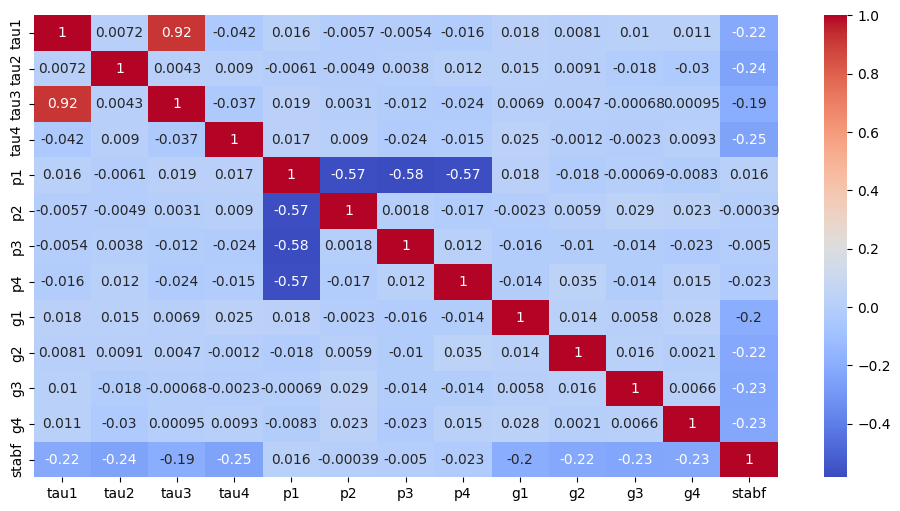

In [ ]:
# Checking it the test heatmap is similar to the training heatmap, in order to be sure
plt.figure(figsize=(12,6))
sns.heatmap(test_data.corr(), cmap='coolwarm', annot=True)

In [ ]:
# Drop the features that were also not trained
test_data = test_data.drop(['p1', 'tau1'], axis=1)

In [ ]:
# Show the test data
test_data.head()

,tau2,tau3,tau4,p2,p3,p4,g1,g2,g3,g4,stabf
0,1.998723,3.198395,6.749158,-1.025326,-0.975754,-1.839274,0.705793,0.061484,0.655529,0.716621,0
1,0.390647,7.295651,2.238956,-0.850468,-1.162358,-0.513991,0.818904,0.917692,0.331460,0.161048,1
2,5.681400,3.766899,6.464329,-1.143055,-1.076921,-0.985898,0.721218,0.283222,0.519634,0.810315,0
3,5.363109,1.412934,6.172790,-0.879606,-1.127544,-1.380928,0.109811,0.633781,0.079277,0.841257,0
4,7.751648,2.488778,5.558753,-1.391981,-0.747310,-0.805910,0.608805,0.509664,0.622356,0.394018,0


<Axes: >

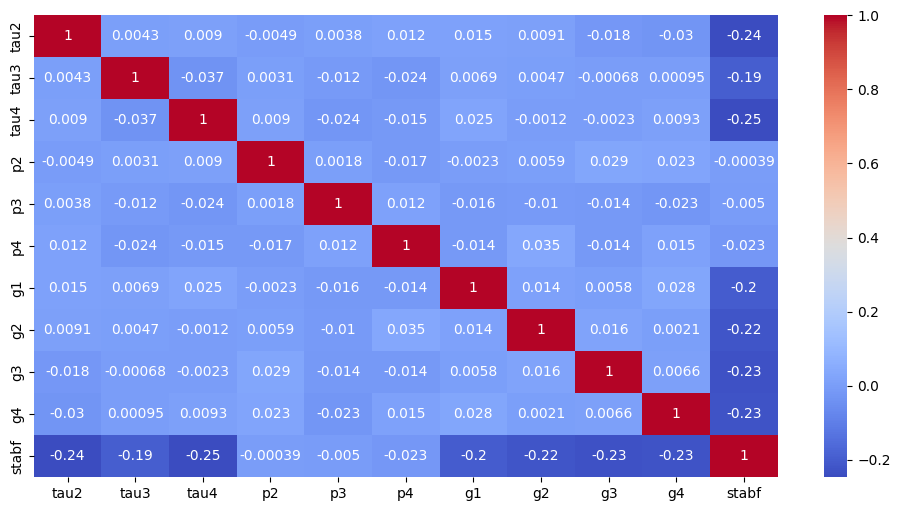

In [ ]:
# Draw a heatmap
plt.figure(figsize=(12,6))
sns.heatmap(test_data.corr(), cmap='coolwarm', annot=True)

# Model

In [ ]:
# Prepare the test features (X_test) by dropping the 'stabf' column
X_test = test_data.drop('stabf', axis=1)

# Prepare the test labels (y_test) by extracting only the 'stabf' column
y_test = test_data.stabf

In [ ]:
# Make predictions on the test data using the trained XGBoost model (model_grid_xgb)
predictions = model_grid_xgb.predict(X_test)

In [ ]:
# Calculate accuracy, recall, F1 score, precision
# Compare the actual 'stabf' column with the predicted column
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Print the results
print(f"Test Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1-score: {f1}")

Test Accuracy: 0.8528
Recall: 0.7637362637362637
Precision: 0.8195754716981132
F1-score: 0.7906712172923777
